In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import netket as nk
from scipy import stats as sp_stats

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import HistoryHandler, VarHandler
from functions import compute_RE, get_timing_info
from Paper.figure_scripts import common
from Archs.arch_utils import get_arch
from functions import get_params_string

In [2]:
L = 64
alpha = 1
arch = f"RBM_alpha{alpha}"
n_dim = 1
PBC = True
dtype_labels = [None, "f32", "f16", "bf16"]
model_labels = ["Heisenberg"]
model_params = [{"J": 1}]

folder = f"{PROJECT_ROOT}Data/History/"

In [3]:
loss_functions = [[None for _ in dtype_labels] for _ in model_labels]
variance = [[None for _ in dtype_labels] for _ in model_labels]
total_time = [[None for _ in dtype_labels] for _ in model_labels]
re = [[None for _ in dtype_labels] for _ in model_labels]
timinig_info = [[None for _ in dtype_labels] for _ in model_labels]
DMRG_energies = []

for m in range(len(model_labels)):
    df_dmrg = pd.read_csv(f"{PROJECT_ROOT}Data/DMRG/Energy/{model_labels[m]}_1dim.csv")
    for key, value in model_params[m].items():
        df_dmrg = df_dmrg[df_dmrg[key] == value] 
    df_dmrg = df_dmrg[df_dmrg["L"] == L] 
    DMRG_energies.append(df_dmrg["energy"].to_numpy())

    for d in range(len(dtype_labels)):
        if dtype_labels[d] is not None:
            _folder = f"LPS/{dtype_labels[d]}/"
        else:
            _folder = "" 
        name = f"{folder}{_folder}MC/"
        hh = HistoryHandler(name, model_labels[m], arch, L, PBC, n_dim, **model_params[m])
        df = hh.load_history()

        loss_functions[m][d] = df["Mean"].to_numpy()
        variance[m][d] = df["Variance"].to_numpy()
        total_time[m][d] = df["total_time"].to_numpy()[0]
        re[m][d] = compute_RE(DMRG_energies[-1], df["Mean"].to_numpy())
        timinig_info[m][d] = get_timing_info(hh.history_file)

DMRG_energies = np.array(DMRG_energies)
dtype_labels[0] = "f64"

In [4]:
L = 12
n_dim = 1
PBC = True
arch = "RBM_alpha1"
dtype_labels = ["f32", "f16", "bf16"]
model_labels = ["Heisenberg"]
model_params = [{"J": 1}]

folder = f"{PROJECT_ROOT}/Data/LPSE/"

In [5]:
eps = []
mean_ref = []
error_ref = []
mean_delta = []
error_delta = []
z = []

for m, model_label in enumerate(model_labels):
    params_str = get_params_string(model_params[m])
    df_eps = pd.read_csv(f"{folder}Eps/FE/{model_label}{params_str}_{arch}_L{L}_{n_dim}dim.csv")
    df_energy = pd.read_csv(f"{folder}Energy/FE/{model_label}{params_str}_{arch}_L{L}_{n_dim}dim.csv")

    mean_ref.append(np.unique(df_energy["E_mean_ref"].to_numpy())[0])
    error_ref.append(np.unique(df_energy["E_error_ref"].to_numpy())[0])
    e = []

    for dtype_label in dtype_labels:
        e.append(df_eps[dtype_label].to_numpy())
        mean_delta.append(df_energy[df_energy["dtypes"] == dtype_label]["E_mean_delta"].to_numpy())
        error_delta.append(df_energy[df_energy["dtypes"] == dtype_label]["E_error_delta"].to_numpy())
        z.append(df_energy[df_energy["dtypes"] == dtype_label]["z"].to_numpy())

    eps.append(np.array(e).reshape((len(dtype_labels), -1)))
mean_delta = np.array(mean_delta).reshape((len(model_labels), -1))
error_delta = np.array(error_delta).reshape((len(model_labels), -1))
mean_ref = np.array(mean_ref)
error_ref = np.array(error_ref)
z = np.array(z).reshape((len(model_labels), -1))

D_delta = mean_ref[:, None] - mean_delta

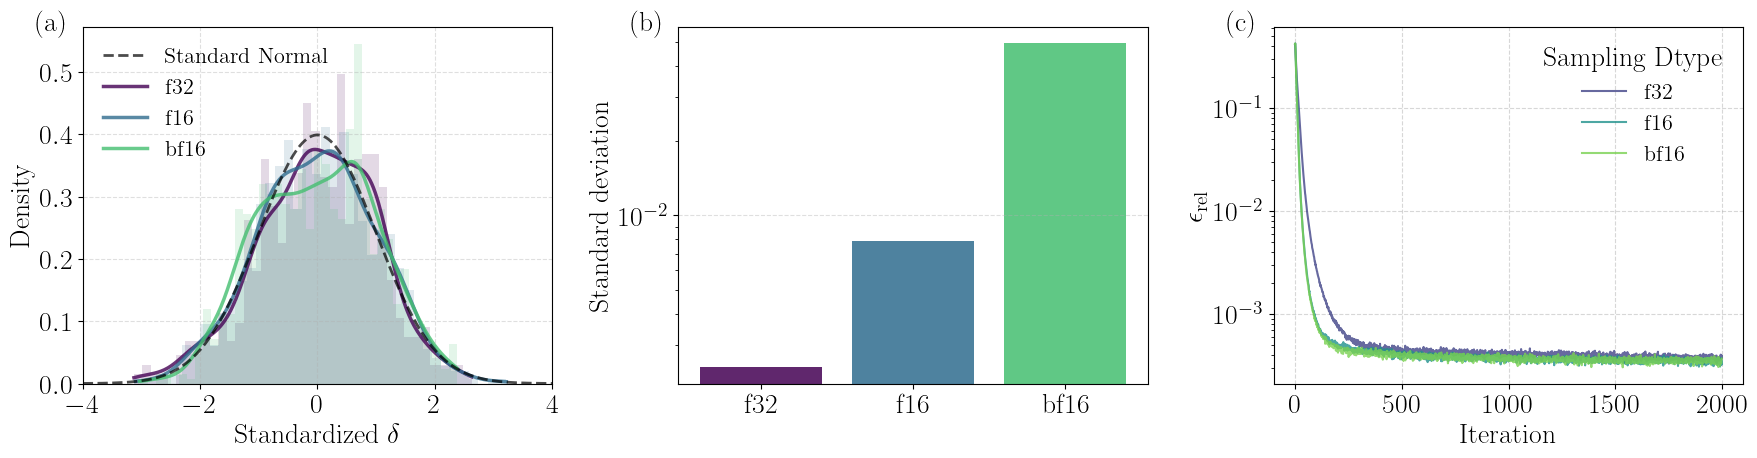

In [9]:
colors_kde = plt.cm.viridis(np.linspace(0, 0.7, len(dtype_labels)))
colors_iter = plt.cm.viridis(np.linspace(0.2, 0.8, len(dtype_labels)))

eps_subset = eps[-1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax_kde = axes[0]
ax_kde.text(-0.1, 1.05, '(a)', transform=ax_kde.transAxes, fontweight='bold', va='top')

x_ref = np.linspace(-4, 4, 200)
ax_kde.plot(x_ref, sp_stats.norm.pdf(x_ref), 'k--', linewidth=2, 
            label='Standard Normal', alpha=0.7, zorder=10)

for i, e in enumerate(eps_subset):
    e_standardized = (e - np.mean(e)) / np.std(e)

    density = sp_stats.gaussian_kde(e_standardized)
    x_plot = np.linspace(e_standardized.min(), e_standardized.max(), 200)
    ax_kde.plot(x_plot, density(x_plot), color=colors_kde[i], linewidth=2.5, 
                label=dtype_labels[i], alpha=0.8)

    ax_kde.hist(e_standardized, bins=40, alpha=0.15, color=colors_kde[i], 
                edgecolor='none', density=True)

ax_kde.legend(loc='upper left', frameon=False)
ax_kde.set_xlabel(r"Standardized $\delta$")
ax_kde.set_ylabel("Density")
ax_kde.grid(True, linestyle='--', alpha=0.4)
ax_kde.set_xlim(-4, 4)

ax_bar = axes[1]
ax_bar.text(-0.1, 1.05, '(b)', transform=ax_bar.transAxes, fontweight='bold', va='top')

bars = [np.std(e) for e in eps_subset]
bar_colors = list(colors_kde) + ["#E64B35"]

ax_bar.bar(np.arange(len(bars)), bars, color=bar_colors, alpha=0.85)
ax_bar.set_yscale("log")
ax_bar.set_xticks(np.arange(len(bars)))
ax_bar.set_xticklabels(dtype_labels)
ax_bar.set_ylabel("Standard deviation")
ax_bar.grid(True, linestyle="--", alpha=0.4, axis="y")

ax_iter = axes[2]
ax_iter.text(-0.1, 1.05, '(c)', transform=ax_iter.transAxes, fontweight='bold', va='top')

for m in range(len(model_labels)):
    for d in range(len(dtype_labels)):
        x = np.arange(len(loss_functions[m][d]))
        y = re[m][d]
        ax_iter.plot(x, y, color=colors_iter[d], label=dtype_labels[d], alpha=0.8)

ax_iter.set_ylabel(r"$\epsilon_{\mathrm{rel}}$")
ax_iter.set_xlabel("Iteration")
ax_iter.set_yscale("log")
ax_iter.grid(True, linestyle="--", alpha=0.5)
ax_iter.legend(title="Sampling Dtype", frameon=False)

plt.tight_layout()
plt.savefig("figures/Heisenberg.pdf")
plt.show()